In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
import networkx as nx
import os
import helper
import random

/home/alok/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alok/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
class GraphDQN(nn.Module): # Input features → GCNConv1 → ReLU → GCNConv2 → ReLU → Linear → Output
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphDQN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return x 

In [3]:
def convert_nx_to_torch_geo(nx_graph):
    for node in nx_graph.nodes():
        if 'feature' not in nx_graph.nodes[node]:
            nx_graph.nodes[node]['feature'] = torch.rand(10) 
    
    data = from_networkx(nx_graph)
    data.x = torch.stack([data.feature[i] for i in range(len(data.feature))])
    return data

In [4]:
def train_dqn(model, graph_list, optimizer, criterion, num_episodes):
    for episode in range(num_episodes):
        for graph in graph_list:
            graph_data = convert_nx_to_torch_geo(graph)
            node_features = graph_data.x
            edge_index = graph_data.edge_index
            
            q_values = model(node_features, edge_index)

            target_q_values = torch.rand(q_values.size())

            loss = criterion(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [5]:
# def get_most_influential_nodes(model, nx_graph, top_k=5):
#     model.eval()  
#     graph_data = convert_nx_to_torch_geo(nx_graph)
    
#     with torch.no_grad():
#         node_features = graph_data.x
#         edge_index = graph_data.edge_index

#         q_values = model(node_features, edge_index)

#     _, top_nodes = torch.topk(q_values.squeeze(), k=top_k)
    
#     return top_nodes.tolist()

In [6]:
def get_most_influential_nodes(model, nx_graph, top_k=5):
    model.eval() 
    graph_data = convert_nx_to_torch_geo(nx_graph)
    
    with torch.no_grad():
        node_features = graph_data.x
        edge_index = graph_data.edge_index
        
   
        q_values = model(node_features, edge_index)
    
    with torch.no_grad():
        node_features = graph_data.x
        edge_index = graph_data.edge_index
        
   
        q_values = model(node_features, edge_index)
    
    _, top_indices = torch.topk(q_values.squeeze(), k=top_k)

    node_mapping = list(nx_graph.nodes) 
    top_nodes = [node_mapping[i] for i in top_indices.tolist()]

    return top_nodes
    
    _, top_indices = torch.topk(q_values.squeeze(), k=top_k)

    node_mapping = list(nx_graph.nodes) 
    top_nodes = [node_mapping[i] for i in top_indices.tolist()]

    return top_nodes

In [7]:
files = os.listdir("dataset")

edges = []
for i in files:
    if i.endswith(".edges"):
        edges.append(i)

graph_list = []

for i in edges:
    graph = helper.read_graph(f"dataset/{i}")
    circle_filename = i.split(".")[0]
    colored_graph = helper.assign_colors_to_nodes(graph, f'dataset/{circle_filename}.circles')
    graph_list.append(colored_graph)


In [8]:
len(graph_list)

10

In [9]:
# graph1 = nx.karate_club_graph()
# graph2 = nx.erdos_renyi_graph(34, 0.05)

# graph_list = [graph1, graph2]

In [10]:
input_dim = 10 
hidden_dim = 32
output_dim = 1


In [11]:
model = GraphDQN(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [12]:
num_episodes = 100
train_dqn(model, graph_list, optimizer, criterion, num_episodes)

## Saving model

In [13]:
torch.save(model.state_dict(), 'graph_dqn_model.pth')

---

---

## Testing with a new graph

In [14]:
graphname = "12831.edges"
test_graph = helper.read_graph(graphname)
circle_filename = graphname.split(".")[0]
test_graph_color = helper.assign_colors_to_nodes(test_graph, f'{circle_filename}.circles')

In [15]:
test_graph_color

In [16]:
# test_graph = nx.karate_club_graph() 
top_nodes = get_most_influential_nodes(model, test_graph_color, top_k=5)
print("Top 5 Influential Nodes:", top_nodes)

Top 5 Influential Nodes: [245421629, 458897186, 19507576, 275570583, 16004268]


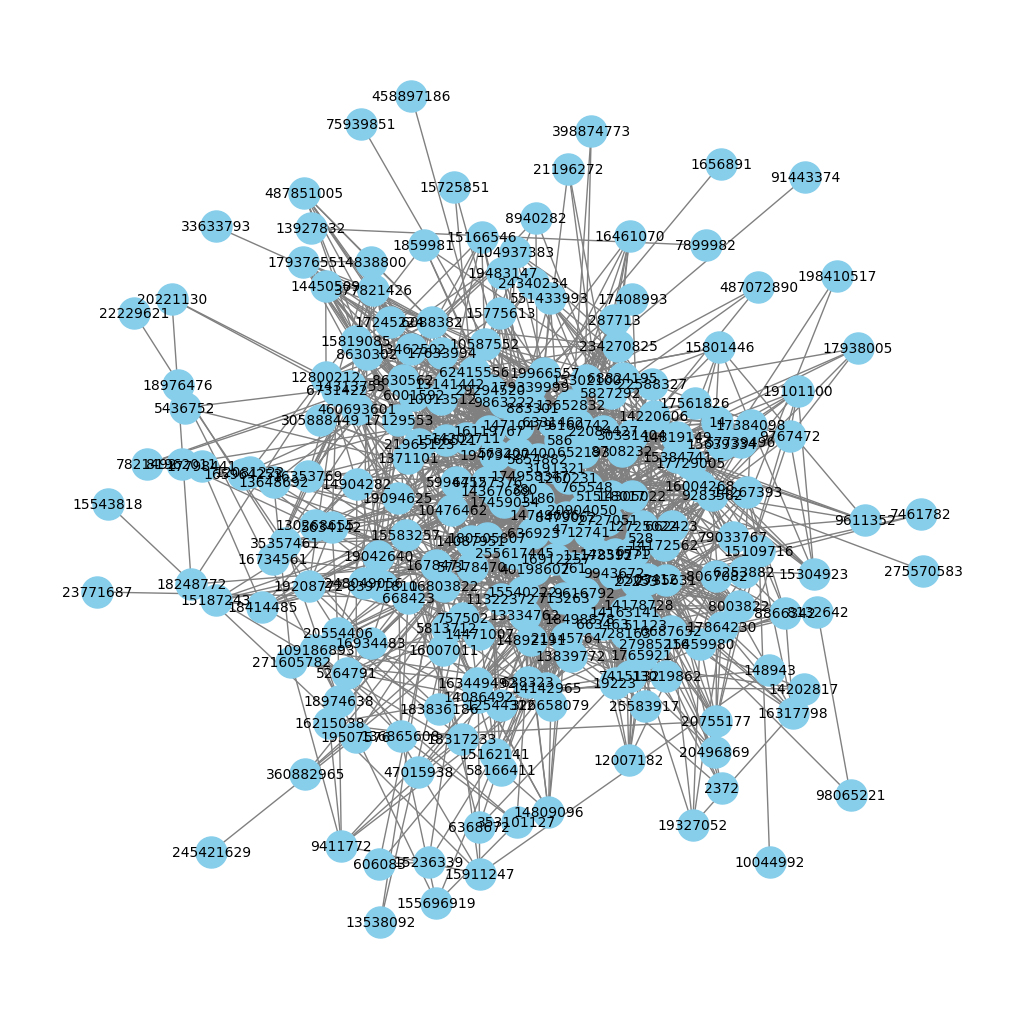

In [17]:
helper.display_graph(test_graph)

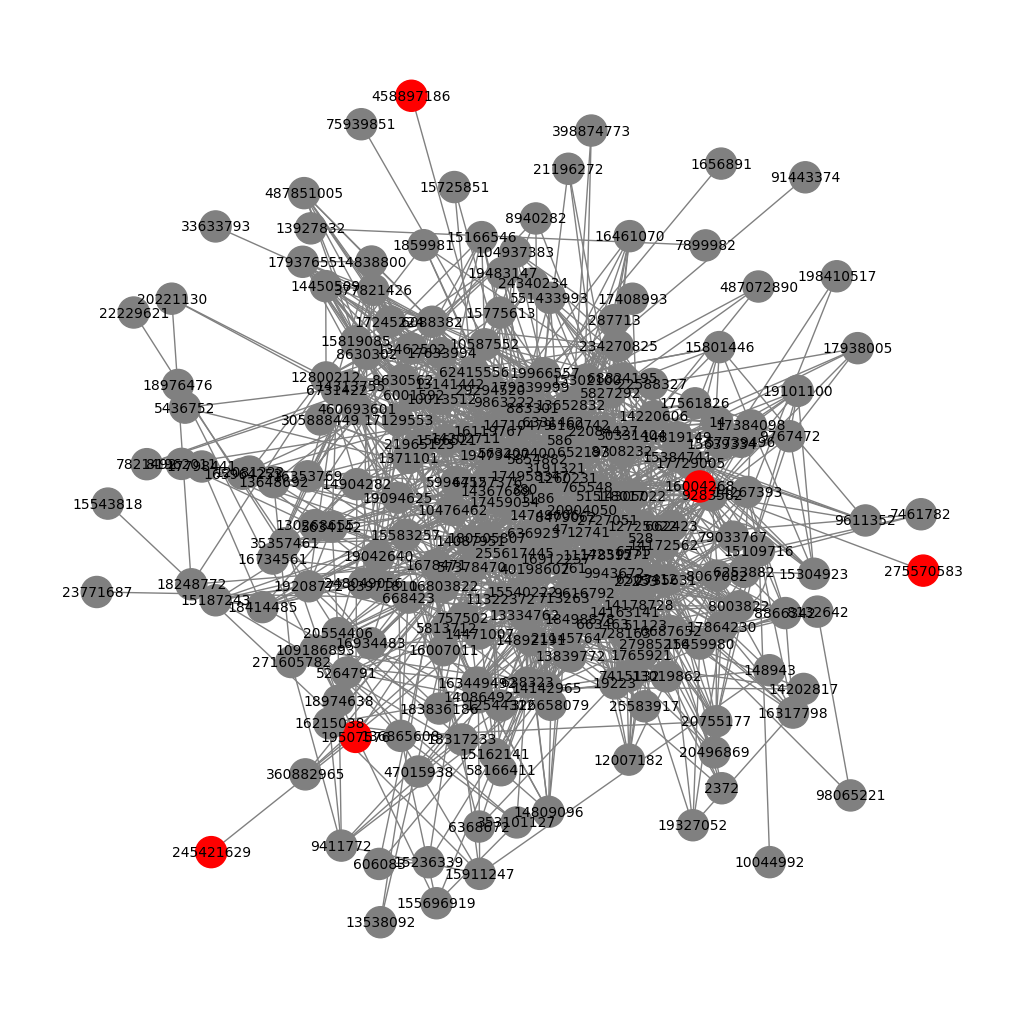

In [18]:
outputGraph = helper.color_specific_nodes_red(test_graph, top_nodes)
helper.display_colored_graph(outputGraph)

In [19]:
# coloured_graph = helper.color_specific_nodes_red(test_graph, top_nodes)
# helper.display_colored_graph(colored_graph)

---

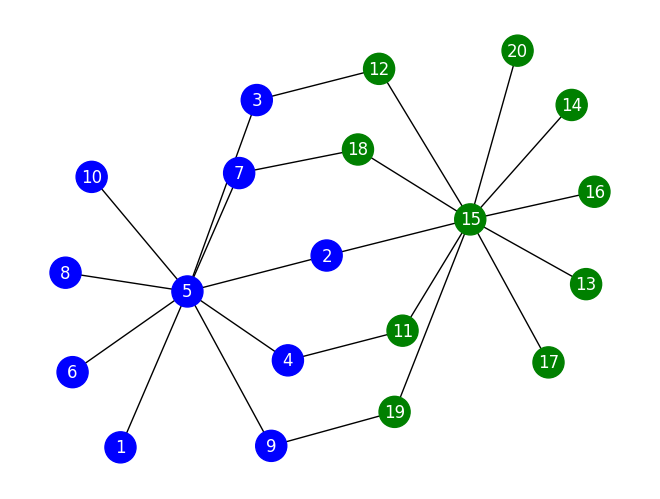

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add nodes 1 to 20
G.add_nodes_from(range(1, 21))

# Add edges for node 5
edges_5 = [(5, i) for i in [1, 2, 3, 4, 6, 7, 8, 9, 10]]
G.add_edges_from(edges_5)

# Add edges for node 15
edges_15 = [(15, i) for i in [11, 12, 13, 14, 16, 17, 18, 19, 20]]
G.add_edges_from(edges_15)

# Add some connections between the two sub-networks
cross_edges = [(3, 12), (7, 18), (2, 15), (9, 19), (4, 11)]  # Sample cross-connections
G.add_edges_from(cross_edges)

# Color nodes: first 10 nodes blue, next 10 nodes green
node_colors = ['blue' if node <= 10 else 'green' for node in G.nodes]

# Draw the graph with color
pos = nx.spring_layout(G)  # Positioning the nodes
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_color='white')

# Show the graph
plt.show()


Top 5 Influential Nodes: [5, 15]


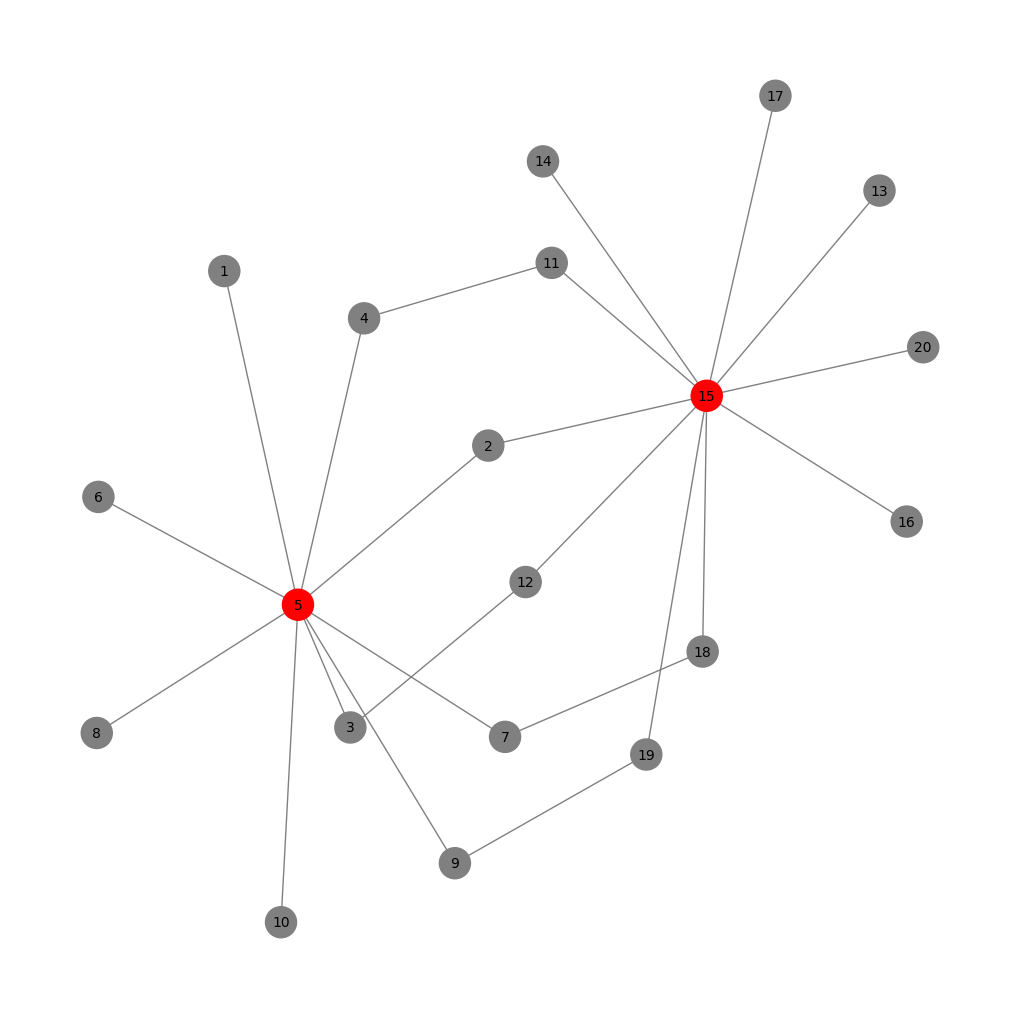

In [21]:
test_graph = G  # This is the graph created above

top_nodes = get_most_influential_nodes(model, test_graph, top_k=2)
print("Top 5 Influential Nodes:", top_nodes)

outputGraph = helper.color_specific_nodes_red(test_graph, top_nodes)
helper.display_colored_graph(outputGraph)


---